In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import snowflake.connector
import plotly.express as px

In [2]:
data = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

In [4]:
data.head(5)

DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700     3   
3  200907217  05/10/2023 12:00:00 AM  03/10/2020 12:00:00 AM      2037     9   
4  200412582  09/09/2020 12:00:00 AM  09/09/2020 12:00:00 AM       630     4   

    AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0    Wilshire          784         1     510   
1     Central          182         1     330   
2   Southwest          356         1     480   
3    Van Nuys          964         1     343   
4  Hollenbeck          413         1     510   

                                Crm Cd Desc  ... Status   Status Desc  \
0                          VEHICLE - STOLEN  ...     AA  Adult Arrest   
1                     BURGLARY FROM VEHICLE  ...     IC   Invest Cont   
2                             BIKE - STOLEN  ...     IC   Invest Cont   
3  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)  ...     IC   Invest Cont   
4                          VEHICLE - STOLEN  ...     IC   Invest Cont   

  Crm Cd 1 Crm Cd 2  Crm Cd 3 Crm Cd 4  \
0    510.0    998.0       NaN      NaN   
1    330.0    998.0       NaN      NaN   
2    480.0      NaN       NaN      NaN   
3    343.0      NaN       NaN      NaN   
4    510.0      NaN       NaN      NaN   

                                   LOCATION Cross Street      LAT       LON  
0   1900 S  LONGWOOD                     AV          NaN  34.0375 -118.3506  
1   1000 S  FLOWER                       ST          NaN  34.0444 -118.2628  
2   1400 W  37TH                         ST          NaN  34.0210 -118.3002  
3  14000    RIVERSIDE                    DR          NaN  34.1576 -118.4387  
4                          200 E  AVENUE 28          NaN  34.0820 -118.2130  

[5 rows x 28 columns]

In [5]:
print(data.columns)

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')


## Explaining the data columns

### Column Name	Description
**DR_NO**:	      Division of Records Number – a unique crime incident ID (primary key).<br>
**Date Rptd**:	  Date the crime was reported to the police.<br>
**DATE OCC**:	  Date the crime actually occurred.<br>
**TIME OCC**:	  Time (in 24-hour format) the crime occurred (e.g., 2130 = 9:30 PM).<br>
**AREA**:	      Numeric code for the LAPD geographic division where the crime occurred.<br>
**AREA NAME**:	  Name of the LAPD geographic division (e.g., Wilshire, Central, etc.).<br>
**Rpt Dist No**:  Reporting district number within the area – a sub-division code.<br>
**Part 1-2**:	  Crime classification: Part 1 (serious crimes like murder, robbery) or Part 2 (less serious).<br>
**Crm Cd**:	      Primary crime code describing the type of crime.<br>
**Crm Cd Desc**:  Human-readable description of the primary crime (e.g., “BURGLARY FROM VEHICLE”).<br>
**Mocodes**:	  Modus operandi codes used internally by LAPD to describe how the crime was committed.<br>
**Vict Age**:	  Age of the victim.<br>
**Vict Sex**:	  Sex of the victim (M, F, or X for unknown).<br>
**Vict Descent**: Victim’s ethnic descent (e.g., W for White, B for Black, H for Hispanic, etc.).<br>
**Premis Cd**:	  Code representing the type of premises (e.g., street, store, residence).<br>
**Premis Desc**:  Description of the premises where the crime occurred.<br>
**Weapon Used**:  Cd	Code for weapon used (if any).<br>
**Weapon Desc**:  Description of the weapon used in the crime.<br>
**Status**:	      Case status code (IC, AA, AD, etc.).<br>
**Status Desc**:  Status description (e.g., “Invest Cont” = Investigation Continuing, “Adult Arrest”).<br>
**Crm Cd 1–4**:	  Up to 4 additional crime codes associated with the incident, if applicable.<br>
**LOCATION**:	  General location of the incident (street and number, sometimes partial).<br>
**Cross Street**: Nearest intersecting street (may be missing for some records).<br>
**LAT**:	      Latitude coordinate of the crime.<br>
**LON**:	      Longitude coordinate of the crime.<br>

In [6]:
print(data.isna().sum()[data.isna().sum() > 0])

Mocodes            151705
Vict Sex           144729
Vict Descent       144741
Premis Cd              16
Premis Desc           588
Weapon Used Cd     677841
Weapon Desc        677841
Status                  1
Crm Cd 1               11
Crm Cd 2           935934
Crm Cd 3          1002777
Crm Cd 4          1005027
Cross Street       850854
dtype: int64


In [10]:
# Convert date columns to datetime
data['Date Rptd'] = pd.to_datetime(data['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [11]:
# Convert TIME OCC to string and pad with zeros to ensure 4 digits (e.g., '2130')
data['TIME OCC'] = data['TIME OCC'].astype(str).str.zfill(4)

In [13]:
# Extracting an important feature to use later on
data['Hour OCC'] = data['TIME OCC'].astype(int) // 100

In [14]:
missing = data.isnull().sum().sort_values(ascending=False)

In [15]:
print(missing)

Crm Cd 4          1005027
Crm Cd 3          1002777
Crm Cd 2           935934
Cross Street       850854
Weapon Desc        677841
Weapon Used Cd     677841
Mocodes            151705
Vict Descent       144741
Vict Sex           144729
Premis Desc           588
Premis Cd              16
Crm Cd 1               11
Status                  1
LOCATION                0
LAT                     0
LON                     0
Status Desc             0
DR_NO                   0
Date Rptd               0
Vict Age                0
Crm Cd Desc             0
Crm Cd                  0
Part 1-2                0
Rpt Dist No             0
AREA NAME               0
AREA                    0
TIME OCC                0
DATE OCC                0
Hour OCC                0
dtype: int64


In [16]:
# Dropping heavily missing additional crime codes columns
data.drop(['Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street'], axis=1, inplace=True)

In [17]:
# Handlin the missing values
# All crimes dont involve weapons... replace the missing value with 'None'
data['Weapon Desc'] = data['Weapon Desc'].fillna('None')
data['Weapon Used Cd'] = data['Weapon Used Cd'].fillna(0)

# Fill victim sex/descent with 'Unknown'
data['Vict Sex'] = data['Vict Sex'].fillna('Unknown')
data['Vict Descent'] = data['Vict Descent'].fillna('Unknown')

# Optional: Fill mocodes as 'None' if needed
data['Mocodes'] = data['Mocodes'].fillna('None')



In [67]:
data.isnull().sum()

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes                0
Vict Age               0
Vict Sex               0
Vict Descent           0
Premis Cd              0
Premis Desc            0
Weapon Used Cd         0
Weapon Desc            0
Status                 0
Status Desc            0
Crm Cd 1               0
LOCATION               0
LAT                    0
LON                    0
Hour OCC               0
DayOfWeek              0
Month                  0
Year                   0
IsWeekend              0
Time_Slot              0
Victim Age Group       0
Season                 0
Report Delay (days)    0
Weapon Used Flag       0
Crime Severity         0
Crime Type Group       0
Location Type          0
Reporting Delay        0
Geohash                0
dtype: int64

In [19]:
# Dropping the rows with premis desc null values (a very few)
data.dropna(subset=['Premis Desc', 'Premis Cd', 'Crm Cd 1', 'Status'], inplace=True)

In [66]:
print(data['TIME OCC'])

0          2130
1          1800
2          1700
3          2037
4          0630
           ... 
1005086    1530
1005087    2100
1005088    2100
1005089    1550
1005090    1235
Name: TIME OCC, Length: 1004492, dtype: object


In [22]:
# Identifying Main categorical columns
categorical_cols = ['AREA NAME', 'Crm Cd Desc', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc', 'Status Desc']

for col in categorical_cols:
    data[col] = data[col].astype('category')


## Feature Engineering

In [23]:
# Adding additional features to use them in future analysis

data['DayOfWeek'] = data['DATE OCC'].dt.day_name()
data['Month'] = data['DATE OCC'].dt.month
data['Year'] = data['DATE OCC'].dt.year
data['IsWeekend'] = data['DayOfWeek'].isin(['Saturday', 'Sunday'])

In [24]:
# New feature to categorize the crime based on time

def time_slot(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['Time_Slot'] = data['Hour OCC'].apply(time_slot)
data['Time_Slot'] = data['Time_Slot'].astype('category')


In [25]:
def age_group(age):
    if pd.isna(age): return 'Unknown'
    elif age < 18: return 'Child'
    elif age < 30: return 'Young Adult'
    elif age < 60: return 'Adult'
    else: return 'Senior'

data['Victim Age Group'] = data['Vict Age'].apply(age_group)


In [26]:
# Feature that assigns seasons based on the month of the crime occurrence date.
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['Season'] = data['DATE OCC'].dt.month.apply(get_season)


In [27]:
# Feature to calculate the delay (in days) between when the crime occurred and when it was reported.
data['Report Delay (days)'] = (data['Date Rptd'] - data['DATE OCC']).dt.days

In [28]:
# Feature to mark the crimes with weapons used
data['Weapon Used Flag'] = data['Weapon Used Cd'].apply(lambda x: 0 if x == 0 or pd.isna(x) else 1)

### Rating the crime based on the severity ("High", "Medium", "Low")

In [30]:
print(data['Crm Cd Desc'])
# Feature to rank the crime based on the severity of the crime 

categories = data['Crm Cd Desc'].cat.categories
for i, category in enumerate(categories, 1):
    print(f"{i}: {category}")

0                                           VEHICLE - STOLEN
1                                      BURGLARY FROM VEHICLE
2                                              BIKE - STOLEN
3                   SHOPLIFTING-GRAND THEFT ($950.01 & OVER)
4                                           VEHICLE - STOLEN
                                 ...                        
1005086                                     VEHICLE - STOLEN
1005087    VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...
1005088                                     VEHICLE - STOLEN
1005089                                     VEHICLE - STOLEN
1005090                                    INDECENT EXPOSURE
Name: Crm Cd Desc, Length: 1004492, dtype: category
Categories (140, object): ['ARSON', 'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 'ATTEMPTED ROBBERY', ..., 'VIOLATION OF COURT ORDER', 'VIOLATION OF RESTRAINING ORDER', 'VIOLATION OF TEMPORARY RESTRAINING ORDER', 'WEAPONS PO

In [31]:
severity_mapping = {
    # High Severity Crimes
    'ARSON': 'High',
    'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER': 'High',
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': 'High',
    'CRIMINAL HOMICIDE': 'High',
    'KIDNAPPING': 'High',
    'RAPE, FORCIBLE': 'High',
    'ROBBERY': 'High',
    'SHOTS FIRED AT INHABITED DWELLING': 'High',
    'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT': 'High',
    'INTIMATE PARTNER - AGGRAVATED ASSAULT': 'High',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT': 'High',
    'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS': 'High',
    'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE': 'High',
    'MANSLAUGHTER, NEGLIGENT': 'High',
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH': 'High',
    'SEXUAL PENETRATION W/FOREIGN OBJECT': 'High',
    'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)': 'High',
    'LEWD/LASCIVIOUS ACTS WITH CHILD': 'High',

    # Medium Severity Crimes
    'ATTEMPTED ROBBERY': 'Medium',
    'BATTERY - SIMPLE ASSAULT': 'Medium',
    'BATTERY ON A FIREFIGHTER': 'Medium',
    'BATTERY POLICE (SIMPLE)': 'Medium',
    'BATTERY WITH SEXUAL CONTACT': 'Medium',
    'BRANDISH WEAPON': 'Medium',
    'BURGLARY': 'Medium',
    'BURGLARY FROM VEHICLE': 'Medium',
    'BURGLARY FROM VEHICLE, ATTEMPTED': 'Medium',
    'BURGLARY, ATTEMPTED': 'Medium',
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT': 'Medium',
    'CHILD STEALING': 'Medium',
    'CONSPIRACY': 'Medium',
    'DOCUMENT FORGERY / STOLEN FELONY': 'Medium',
    'DRUGS, TO A MINOR': 'Medium',
    'DISCHARGE FIREARMS/SHOTS FIRED': 'Medium',
    'DISRUPT SCHOOL': 'Medium',
    'EXTORTION': 'Medium',
    'FALSE IMPRISONMENT': 'Medium',
    'INTIMATE PARTNER - SIMPLE ASSAULT': 'Medium',
    'KIDNAPPING - GRAND ATTEMPT': 'Medium',
    'LEWD CONDUCT': 'Medium',
    'LYNCHING': 'Medium',
    'PANDERING': 'Medium',
    'PIMPING': 'Medium',
    'RAPE, ATTEMPTED': 'Medium',
    'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ': 'Medium',
    'STALKING': 'Medium',
    'THEFT FROM PERSON - ATTEMPT': 'Medium',
    'THREATENING PHONE CALLS/LETTERS': 'Medium',
    'TRESPASSING': 'Medium',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'Medium',
    'VIOLATION OF COURT ORDER': 'Medium',
    'VIOLATION OF RESTRAINING ORDER': 'Medium',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER': 'Medium',
    'WEAPONS POSSESSION/BOMBING': 'Medium',

    # Low Severity Crimes (remaining categories assumed low unless noted)
}

# Assign remaining categories as Low
all_categories = list(data['Crm Cd Desc'].cat.categories)
for category in all_categories:
    if category not in severity_mapping:
        severity_mapping[category] = 'Low'

# Map to DataFrame
data['Crime Severity'] = data['Crm Cd Desc'].map(severity_mapping)


### Grouping the crimes based on the "crm cd desc"


In [32]:
crime_type_mapping = {
    # Homicide & Violent Crime
    'CRIMINAL HOMICIDE': 'Homicide',
    'MANSLAUGHTER, NEGLIGENT': 'Homicide',
    'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER': 'Assault',
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': 'Assault',
    'BATTERY - SIMPLE ASSAULT': 'Assault',
    'INTIMATE PARTNER - AGGRAVATED ASSAULT': 'Assault',
    'INTIMATE PARTNER - SIMPLE ASSAULT': 'Assault',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT': 'Assault',
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT': 'Assault',
    'BATTERY POLICE (SIMPLE)': 'Assault',
    'BATTERY ON A FIREFIGHTER': 'Assault',

    # Robbery
    'ROBBERY': 'Robbery',
    'ATTEMPTED ROBBERY': 'Robbery',
    
    # Theft
    'BURGLARY': 'Theft',
    'BURGLARY, ATTEMPTED': 'Theft',
    'BURGLARY FROM VEHICLE': 'Theft',
    'BURGLARY FROM VEHICLE, ATTEMPTED': 'Theft',
    'SHOPLIFTING - PETTY THEFT ($950 & UNDER)': 'Theft',
    'PETTY THEFT - PERSON': 'Theft',
    'PETTY THEFT - AUTO REPAIR SHOP': 'Theft',
    'PETTY THEFT - BICYCLE': 'Theft',
    'PETTY THEFT': 'Theft',
    'GRAND THEFT / INSURANCE FRAUD': 'Theft',
    'GRAND THEFT / AUTO REPAIR SHOP': 'Theft',
    'GRAND THEFT': 'Theft',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)': 'Theft',
    'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)': 'Theft',
    'THEFT OF IDENTITY': 'Theft',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)': 'Theft',
    'DOCUMENT FORGERY / STOLEN FELONY': 'Theft',

    # Sexual Crimes
    'RAPE, FORCIBLE': 'Sex Crime',
    'RAPE, ATTEMPTED': 'Sex Crime',
    'LEWD/LASCIVIOUS ACTS WITH CHILD': 'Sex Crime',
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH': 'Sex Crime',
    'SEXUAL PENETRATION W/FOREIGN OBJECT': 'Sex Crime',
    'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ': 'Sex Crime',
    'BATTERY WITH SEXUAL CONTACT': 'Sex Crime',
    'PIMPING': 'Sex Crime',
    'PANDERING': 'Sex Crime',
    'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS': 'Sex Crime',
    'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE': 'Sex Crime',

    # Weapons
    'WEAPONS POSSESSION/BOMBING': 'Weapons',
    'BRANDISH WEAPON': 'Weapons',
    'DISCHARGE FIREARMS/SHOTS FIRED': 'Weapons',
    'SHOTS FIRED AT INHABITED DWELLING': 'Weapons',
    'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT': 'Weapons',

    # Property Damage
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'Property Damage',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)': 'Property Damage',
    'ARSON': 'Property Damage',

    # Fraud & Financial
    'CREDIT CARDS, FRAUD USE ($950 & UNDER)': 'Fraud',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)': 'Fraud',
    'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)': 'Fraud',
    'COUNTERFEIT': 'Fraud',
    'THEFT OF IDENTITY': 'Fraud',
    'DOCUMENT FORGERY / STOLEN FELONY': 'Fraud',
    'BUNCO, GRAND THEFT': 'Fraud',
    'BUNCO, PETTY THEFT': 'Fraud',

    # Drugs
    'NARCOTICS': 'Drugs',
    'POSSESSION OF NARCOTICS PARAPHERNALIA': 'Drugs',
    'POSSN OF NARCOTICS FOR SALE': 'Drugs',
    'DRUGS, TO A MINOR': 'Drugs',

    # Public Order
    'TRESPASSING': 'Public Order',
    'DISRUPT SCHOOL': 'Public Order',
    'DISTURBING THE PEACE': 'Public Order',
    'CRIMINAL THREATS - NO WEAPON DISPLAYED': 'Public Order',
    'THREATENING PHONE CALLS/LETTERS': 'Public Order',
    'VIOLATION OF RESTRAINING ORDER': 'Public Order',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER': 'Public Order',
    'VIOLATION OF COURT ORDER': 'Public Order',

    # Others
    'STALKING': 'Other',
    'LYNCHING': 'Other',
    'CONSPIRACY': 'Other',
    'LEWD CONDUCT': 'Other',
    'FALSE IMPRISONMENT': 'Other',
    'CHILD STEALING': 'Other',
    'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)': 'Other',
    'KIDNAPPING': 'Other',
    'KIDNAPPING - GRAND ATTEMPT': 'Other'
}

data['Crime Type Group'] = data['Crm Cd Desc'].map(crime_type_mapping).fillna('Other')


### Feature to group based on location type

In [33]:
print(data['Premis Cd'])
print(data['Premis Desc'])

0          101.0
1          128.0
2          502.0
3          405.0
4          101.0
           ...  
1005086    101.0
1005087    108.0
1005088    101.0
1005089    101.0
1005090    721.0
Name: Premis Cd, Length: 1004492, dtype: float64
0                                                STREET
1                     BUS STOP/LAYOVER (ALSO QUERY 124)
2          MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)
3                                        CLOTHING STORE
4                                                STREET
                               ...                     
1005086                                          STREET
1005087                                     PARKING LOT
1005088                                          STREET
1005089                                          STREET
1005090                                     HIGH SCHOOL
Name: Premis Desc, Length: 1004492, dtype: category
Categories (306, object): ['7TH AND METRO CENTER (NOT LINE SPECIFIC)', 'ABANDONED BUILDING ABAND

**Premis Cd**:	  Code representing the type of premises (e.g., street, store, residence).<br>
**Premis Desc**:  Description of the premises where the crime occurred.<br>

In [34]:
location_categories = data['Premis Desc'].cat.categories
for i, category in enumerate(location_categories, 1):
    print(f"{i}: {category}")

1: 7TH AND METRO CENTER (NOT LINE SPECIFIC)
2: ABANDONED BUILDING ABANDONED HOUSE
3: ABATEMENT LOCATION
4: ABORTION CLINIC/ABORTION FACILITY*
5: AIRCRAFT
6: ALLEY
7: AMTRAK TRAIN
8: AMUSEMENT PARK*
9: APARTMENT/CONDO COMMON LAUNDRY ROOM
10: ARCADE,GAME ROOM/VIDEO GAMES (EXAMPLE CHUCKIE CHEESE)*
11: AUTO DEALERSHIP (CHEVY, FORD, BMW, MERCEDES, ETC.)
12: AUTO REPAIR SHOP
13: AUTO SALES LOT
14: AUTO SUPPLY STORE*
15: AUTOMATED TELLER MACHINE (ATM)
16: BALCONY*
17: BANK
18: BANK DROP BOX/MONEY DROP-OUTSIDE OF BANK*
19: BANKING INSIDE MARKET-STORE *
20: BAR/COCKTAIL/NIGHTCLUB
21: BAR/SPORTS BAR (OPEN DAY & NIGHT)
22: BASKETBALL COURTS
23: BEACH
24: BEAUTY SUPPLY STORE
25: BEAUTY/BARBER SHOP
26: BOOK STORE
27: BOWLING ALLEY*
28: BUS DEPOT/TERMINAL, OTHER THAN MTA
29: BUS STOP
30: BUS STOP/LAYOVER (ALSO QUERY 124)
31: BUS, SCHOOL, CHURCH
32: BUS-CHARTER/PRIVATE
33: CAR WASH
34: CATERING/ICE CREAM TRUCK
35: CELL PHONE STORE
36: CEMETARY*
37: CHECK CASHING*
38: CHEMICAL STORAGE/MANUFACTURING PL

In [36]:
def map_location_type(premis):
    premis = str(premis).lower()
    if any(word in premis for word in ['apartment', 'house', 'residence', 'dwelling', 'condo', 'driveway', 'yard', 'garage', 'porch', 'motel', 'hotel']):
        return 'Residential'
    elif any(word in premis for word in ['bank', 'store', 'shop', 'bar', 'restaurant', 'market', 'mall', 'dealership', 'pharmacy', 'liquor', 'salon', 'office', 'fast food']):
        return 'Commercial'
    elif any(word in premis for word in ['school', 'college', 'university', 'day care', 'preschool', 'trade school']):
        return 'Educational'
    elif any(word in premis for word in ['hospital', 'clinic', 'hospice', 'nursing', 'medical', 'convalescent', 'dental']):
        return 'Medical'
    elif any(word in premis for word in ['warehouse', 'factory', 'plant', 'storage', 'manufacturing', 'shed', 'recycling']):
        return 'Industrial'
    elif any(word in premis for word in ['station', 'bus', 'train', 'metro', 'terminal', 'airport', 'freeway', 'vehicle', 'parking', 'tracks', 'stop']):
        return 'Transportation'
    elif any(word in premis for word in ['church', 'mosque', 'temple', 'synagogue', 'chapel']):
        return 'Religious'
    elif any(word in premis for word in ['park', 'playground', 'stadium', 'gym', 'spa', 'arena', 'beach', 'pool', 'club', 'recreation']):
        return 'Recreational'
    elif any(word in premis for word in ['jail', 'courthouse', 'police', 'government', 'fire station', 'post office', 'facility']):
        return 'Government'
    elif any(word in premis for word in ['vacant', 'sidewalk', 'street', 'alley', 'trash', 'underpass', 'bridge', 'encampment', 'outdoor', 'tunnel']):
        return 'Outdoor/Unoccupied'
    else:
        return 'Other'

# Apply to DataFrame
data['Location Type'] = data['Premis Desc'].apply(map_location_type)

In [38]:
# feature to store the reporting delay (in days)

data['Reporting Delay'] = (data['Date Rptd'] - data['DATE OCC']).dt.days

# Geohash Binning

####  Its a way of encoding the lat and lon into a short string of characters that represent a square-ish region on the map.

In [41]:
pip install geohash2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15550 sha256=b3ff2434e8cc11d672436ed2adf49f6384a463274e8fd109f5ecdbed9fcb965f
  Stored in directory: c:\users\orcon\appdata\local\pip\cache\wheels\00\d5\b6\3fbe4088f7912982f596eaddfd593d16096468a2f13e470ae7
Successfully built geohash2
Note: you may need to restart the kernel to use updated packages.


In [42]:
import geohash2

In [43]:
# Create a geohash column with a precision of 5
data['Geohash'] = data.apply(lambda row: geohash2.encode(row['LAT'], row['LON'], precision=5), axis=1)

In [44]:
print(data['Geohash'])

0          9q5cd
1          9q5cs
2          9q5cs
3          9q5f2
4          9q5cv
           ...  
1005086    9q5cs
1005087    9q5cs
1005088    9q5cs
1005089    9q5fc
1005090    9q5fb
Name: Geohash, Length: 1004492, dtype: object


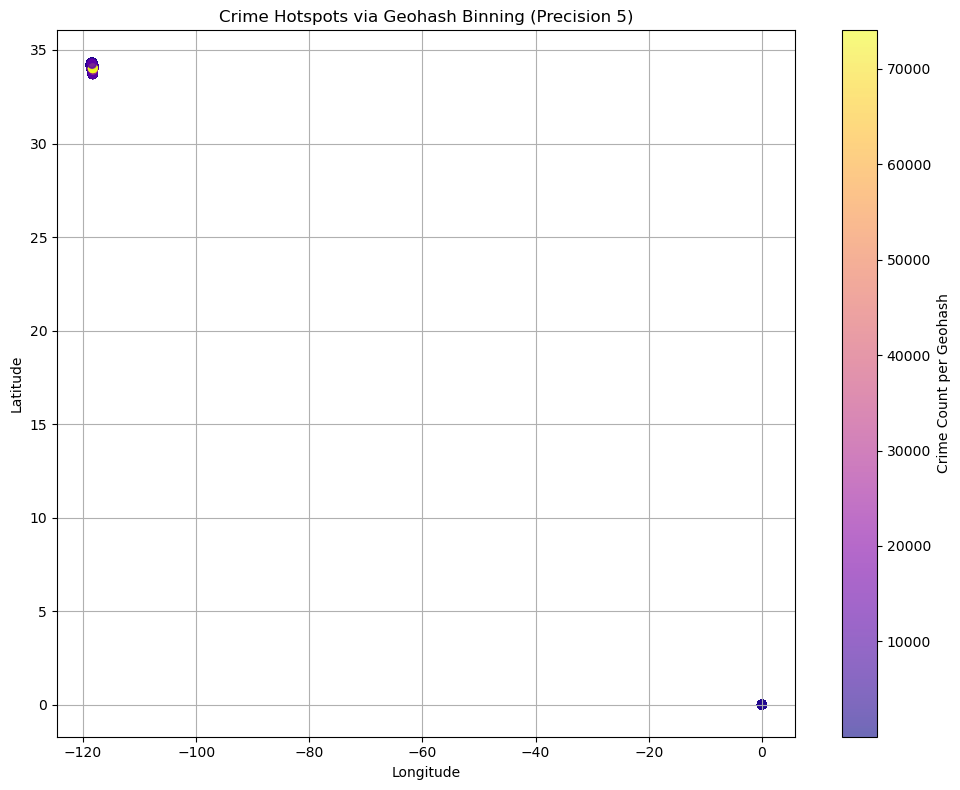

In [46]:
# Simulate mock LAT/LON points (you can replace with your own data)

mock_data=data
# Geohash encoding
mock_data['Geohash'] = mock_data.apply(lambda row: geohash2.encode(row['LAT'], row['LON'], precision=5), axis=1)

# Count crimes per geohash
geo_counts = mock_data['Geohash'].value_counts().reset_index()
geo_counts.columns = ['Geohash', 'Crime Count']

# Merge back for plotting
mock_data = mock_data.merge(geo_counts, on='Geohash')

# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    mock_data['LON'], 
    mock_data['LAT'], 
    c=mock_data['Crime Count'], 
    cmap='plasma', 
    alpha=0.6
)
plt.colorbar(scatter, label='Crime Count per Geohash')
plt.title("Crime Hotspots via Geohash Binning (Precision 5)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

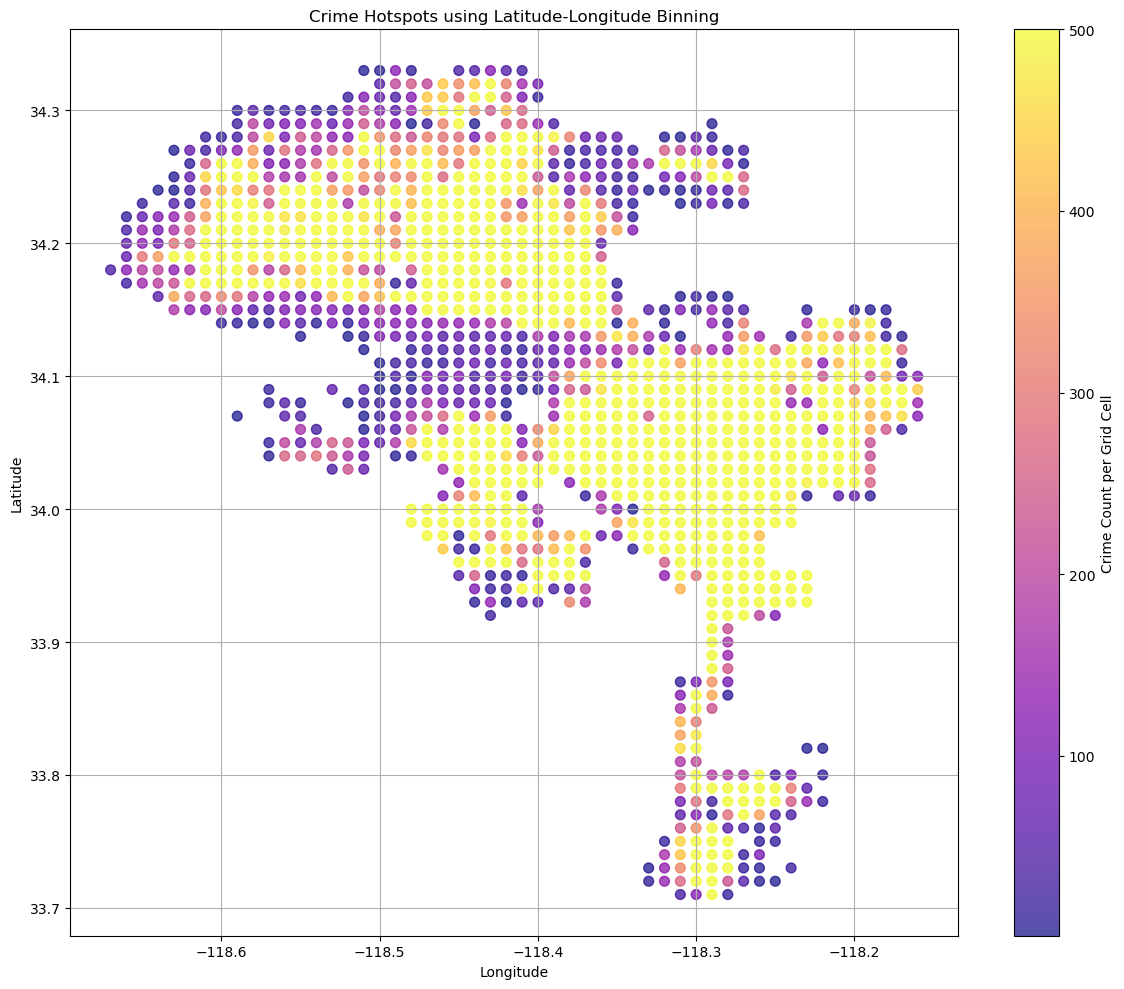

In [49]:

# Make a safe copy
mock_data = data.copy()

# Step 1: Clean GPS coordinates
mock_data = mock_data.dropna(subset=['LAT', 'LON'])
mock_data = mock_data[(mock_data['LAT'] != 0) & (mock_data['LON'] != 0)]
mock_data = mock_data[(mock_data['LAT'].between(33.5, 34.5)) & (mock_data['LON'].between(-119, -117))]

# Step 2: Round coordinates into bins (~1.1km resolution)
mock_data['Lat_bin'] = mock_data['LAT'].round(2)
mock_data['Lon_bin'] = mock_data['LON'].round(2)
mock_data['LatLon_bin'] = mock_data['Lat_bin'].astype(str) + ',' + mock_data['Lon_bin'].astype(str)

# Step 3: Count crimes per bin
bin_counts = mock_data['LatLon_bin'].value_counts().reset_index()
bin_counts.columns = ['LatLon_bin', 'Crime Count']
bin_counts[['Lat_bin', 'Lon_bin']] = bin_counts['LatLon_bin'].str.split(',', expand=True).astype(float)

# Step 4: Visualize
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    bin_counts['Lon_bin'], 
    bin_counts['Lat_bin'], 
    c=bin_counts['Crime Count'].clip(upper=500),  # Adjust as needed
    cmap='plasma', 
    s=50, 
    alpha=0.7
)
plt.colorbar(scatter, label='Crime Count per Grid Cell')
plt.title('Crime Hotspots using Latitude-Longitude Binning')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
columns_to_export = [
    'DR_NO', 'DATE OCC', 'Date Rptd', 'TIME OCC', 'AREA', 'AREA NAME',
    'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
    'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
    'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
    'LOCATION', 'LAT', 'LON', 'Hour OCC', 'DayOfWeek', 'Month', 'Year',
    'IsWeekend', 'Time_Slot', 'Victim Age Group', 'Season',
    'Report Delay (days)', 'Weapon Used Flag', 'Crime Severity',
    'Crime Type Group', 'Location Type', 'Reporting Delay', 'Geohash'
]

# Exporting the data to csv file

In [52]:
mock_data[columns_to_export].to_csv("lapd_cleaned_crime_dataset.csv", index=False)

# Snowflake configurations

In [53]:
pip install snowflake-connector-python

   ---------------------------------------- 0.0/947.3 kB ? eta -:--:--
   ---------------------------------------- 947.3/947.3 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.6 MB ? eta -:--:--
   --- ------------------------------------ 1.0/13.6 MB 4.6 MB/s eta 0:00:03
   ----- ---------------------------------- 1.8/13.6 MB 4.2 MB/s eta 0:00:03
   ------- -------------------------------- 2.6/13.6 MB 4.1 MB/s eta 0:00:03
   ---------- ----------------------------- 3.4/13.6 MB 4.0 MB/s eta 0:00:03
   ------------ --------------------------- 4.2/13.6 MB 4.0 MB/s eta 0:00:03
   -------------- ------------------------- 5.0/13.6 MB 4.0 MB/s eta 0:00:03
   ----------------- ---------------------- 6.0/13.6 MB 4.0 MB/s eta 0:00:02
   ------------------- -------------------- 6.6/13.6 MB 3.9 MB/s eta 0:00:02
   ---------------------- ----------------- 7.6/13.6 MB 3.9 MB/s eta 0:00:02
   ------------------------ --------------- 8.4/13.6 MB 3.9 MB/s eta 0:00:02
   ------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.38.29 which is incompatible.


In [61]:


# Load your cleaned CSV
df = pd.read_csv("lapd_cleaned_crime_dataset.csv")


In [62]:

# Rename DataFrame columns to match Snowflake table
# Rename all columns to match Snowflake exactly (case-sensitive)
df.rename(columns={
    'DATE OCC': 'DATE_OCC',
    'Date Rptd': 'DATE_RPTD',
    'TIME OCC': 'TIME_OCC',
    'AREA NAME': 'AREA_NAME',
    'Rpt Dist No': 'RPT_DIST_NO',
    'Part 1-2': 'PART_1_2',
    'Crm Cd': 'CRM_CD',
    'Crm Cd Desc': 'CRM_CD_DESC',
    'Mocodes': 'MOCODES',
    'Vict Age': 'VICT_AGE',
    'Vict Sex': 'VICT_SEX',
    'Vict Descent': 'VICT_DESCENT',
    'Premis Cd': 'PREMIS_CD',
    'Premis Desc': 'PREMIS_DESC',
    'Weapon Used Cd': 'WEAPON_USED_CD',
    'Weapon Desc': 'WEAPON_DESC',
    'Status': 'STATUS',
    'Status Desc': 'STATUS_DESC',
    'Crm Cd 1': 'CRM_CD_1',
    'Hour OCC': 'HOUR_OCC',
    'DayOfWeek': 'DAYOFWEEK',
    'Month': 'MONTH',
    'Year': 'YEAR',
    'IsWeekend': 'ISWEEKEND',
    'Time_Slot': 'TIME_SLOT',
    'Victim Age Group': 'VICTIM_AGE_GROUP',
    'Season': 'SEASON',
    'Report Delay (days)': 'REPORT_DELAY_DAYS',
    'Weapon Used Flag': 'WEAPON_USED_FLAG',
    'Crime Severity': 'CRIME_SEVERITY',
    'Crime Type Group': 'CRIME_TYPE_GROUP',
    'Location Type': 'LOCATION_TYPE',
    'Reporting Delay': 'REPORTING_DELAY',
    'Geohash': 'GEOHASH'
}, inplace=True)

print(df.columns.tolist())

['DR_NO', 'DATE_OCC', 'DATE_RPTD', 'TIME_OCC', 'AREA', 'AREA_NAME', 'RPT_DIST_NO', 'PART_1_2', 'CRM_CD', 'CRM_CD_DESC', 'MOCODES', 'VICT_AGE', 'VICT_SEX', 'VICT_DESCENT', 'PREMIS_CD', 'PREMIS_DESC', 'WEAPON_USED_CD', 'WEAPON_DESC', 'STATUS', 'STATUS_DESC', 'CRM_CD_1', 'LOCATION', 'LAT', 'LON', 'HOUR_OCC', 'DAYOFWEEK', 'MONTH', 'YEAR', 'ISWEEKEND', 'TIME_SLOT', 'VICTIM_AGE_GROUP', 'SEASON', 'REPORT_DELAY_DAYS', 'WEAPON_USED_FLAG', 'CRIME_SEVERITY', 'CRIME_TYPE_GROUP', 'LOCATION_TYPE', 'REPORTING_DELAY', 'GEOHASH']


In [58]:

# Snowflake credentials
conn = snowflake.connector.connect(
    user='RITHVIKKAZA',
    password='RithvikKaza99@', 
    account='AIYUQJT-GY64873',     
    warehouse='COMPUTE_WH',
    database='CRIME_ANALYTICS',
    schema='LAPD',
    role='ACCOUNTADMIN'
)

cursor = conn.cursor()


In [65]:
#AVOID USING THIS METHOD it takes hours to upload the data in batches

# Insert in chunks

# batch_size = 500
# columns = ', '.join([f'"{col}"' for col in df.columns])

# for start in range(0, len(df), batch_size):
#     batch = df.iloc[start:start + batch_size]
#     values = ",".join(
#         "(" + ",".join(f"'{str(v).replace('\'', '').replace('nan','')}'" for v in row) + ")"
#         for row in batch.values
#     )
#     insert_query = f"INSERT INTO LAPD.CRIME_DATA ({columns}) VALUES {values}"
#     try:
#         cursor.execute(insert_query)
#     except Exception as e:
#         print(f"Error inserting batch starting at row {start}: {e}")

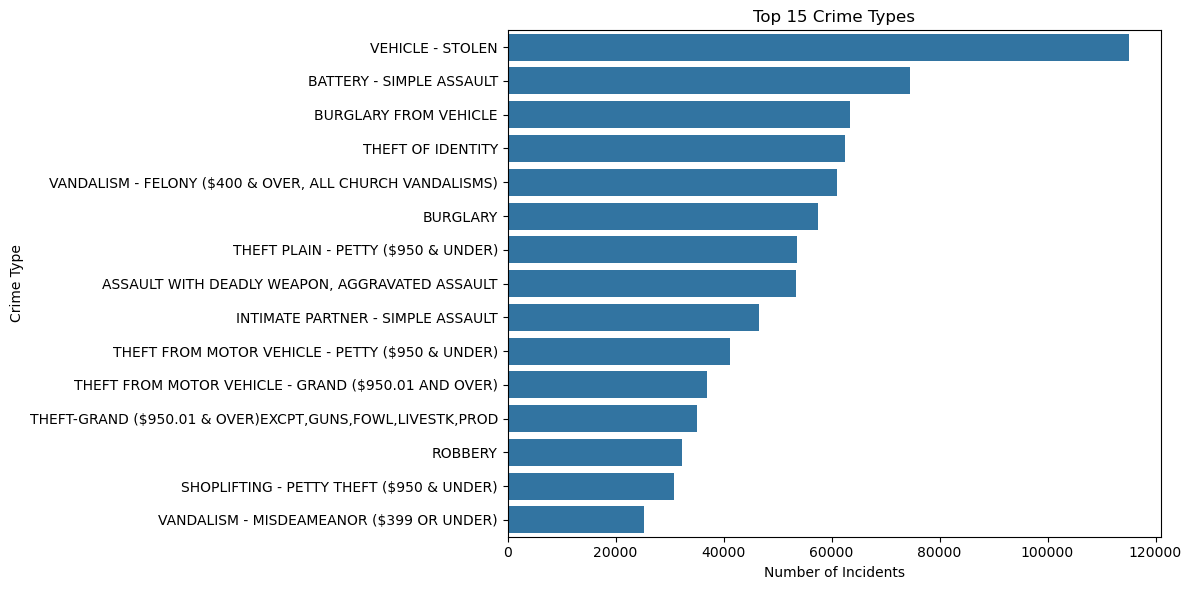

In [72]:
plt.figure(figsize=(12,6))
sns.countplot(y='CRM_CD_DESC', data=df, order=df['CRM_CD_DESC'].value_counts().head(15).index)
plt.title('Top 15 Crime Types')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

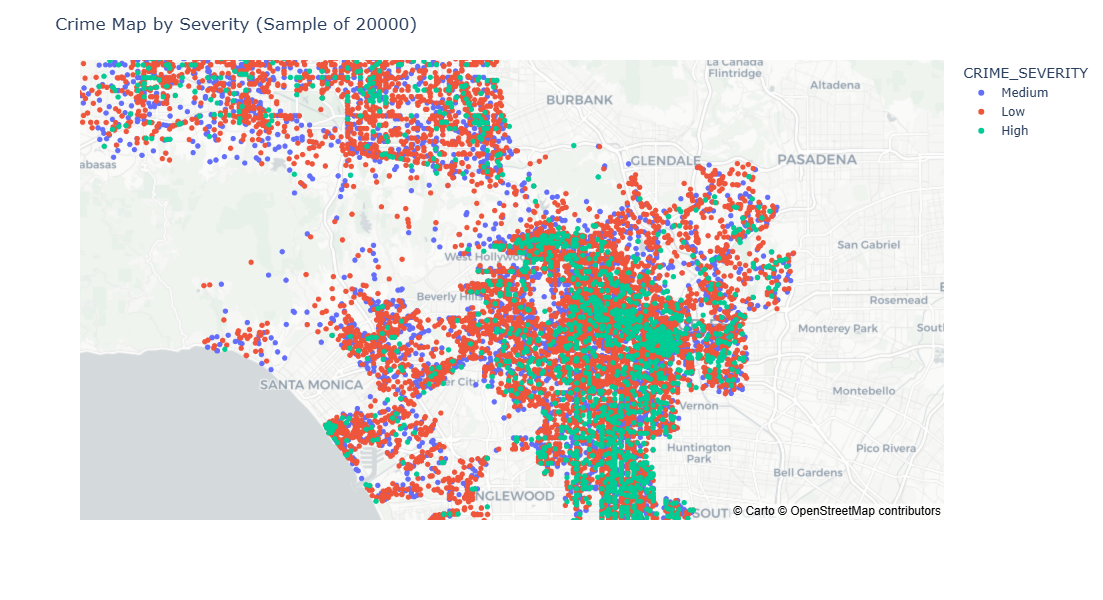

In [78]:
fig = px.scatter_mapbox(df.sample(20000), lat="LAT", lon="LON", 
                        color="CRIME_SEVERITY", hover_name="CRM_CD_DESC",
                        mapbox_style="carto-positron", zoom=10, height=600)
fig.update_layout(title="Crime Map by Severity (Sample of 20000)")
fig.show()


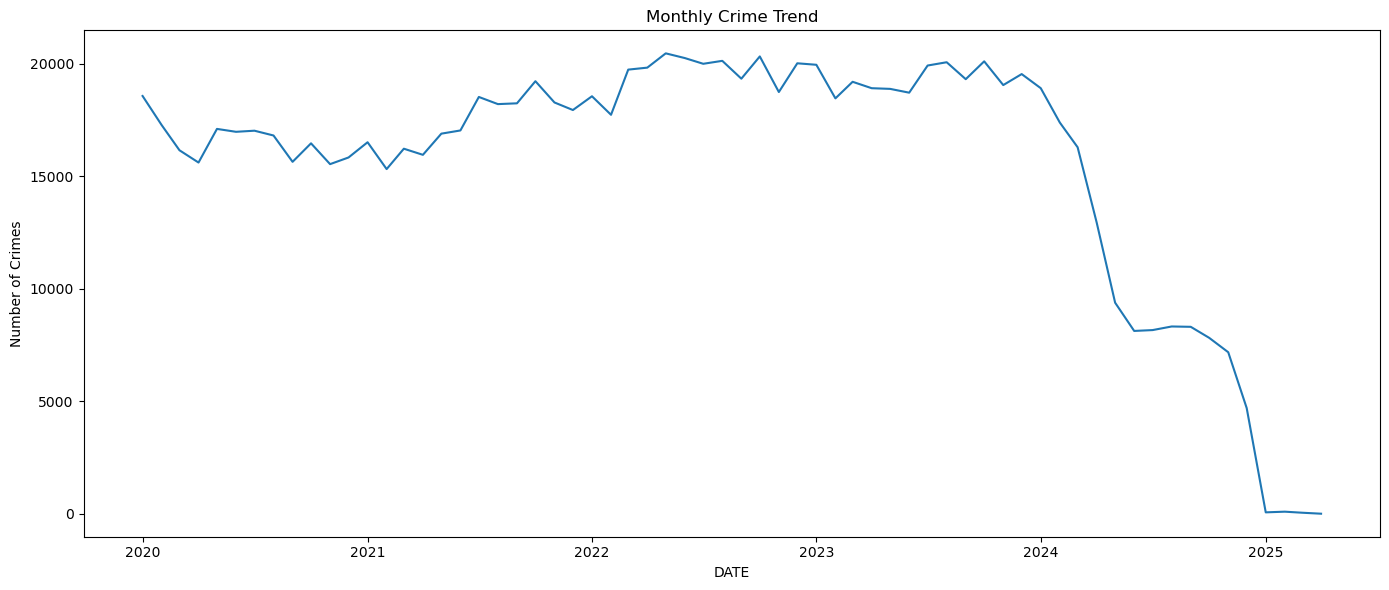

In [81]:
monthly = df.groupby(['YEAR', 'MONTH']).size().reset_index(name='Count')
monthly['DATE'] = pd.to_datetime(monthly[['YEAR', 'MONTH']].assign(DAY=1))

plt.figure(figsize=(14,6))
sns.lineplot(x='DATE', y='Count', data=monthly)
plt.title('Monthly Crime Trend')
plt.xlabel('DATE')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.show()


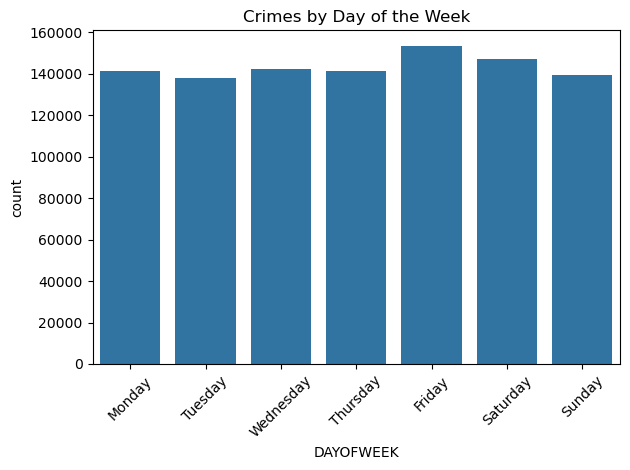

In [83]:
sns.countplot(x='DAYOFWEEK', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Crimes by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


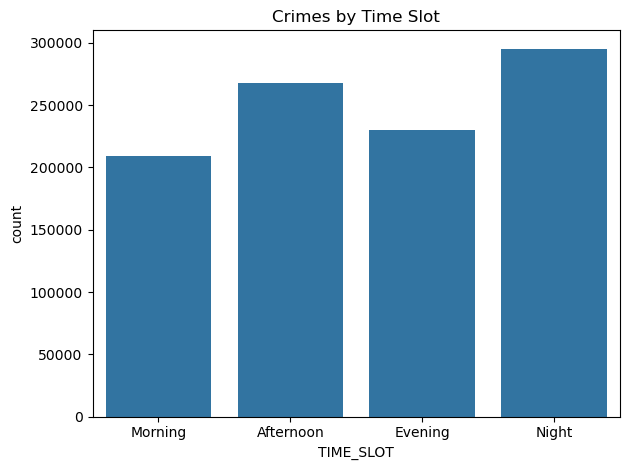

In [85]:
sns.countplot(x='TIME_SLOT', data=df, order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Crimes by Time Slot')
plt.tight_layout()
plt.show()


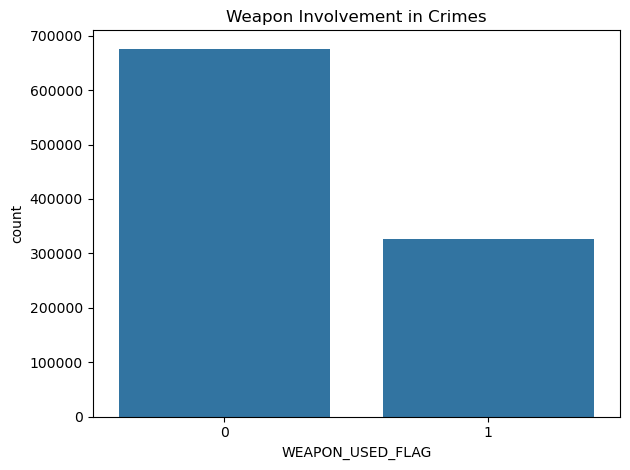

In [87]:
sns.countplot(x='WEAPON_USED_FLAG', data=df)
plt.title('Weapon Involvement in Crimes')
plt.tight_layout()
plt.show()


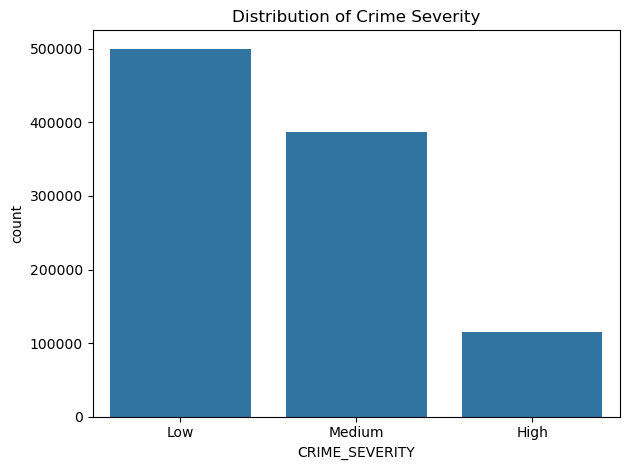

In [88]:
sns.countplot(x='CRIME_SEVERITY', data=df)
plt.title('Distribution of Crime Severity')
plt.tight_layout()
plt.show()


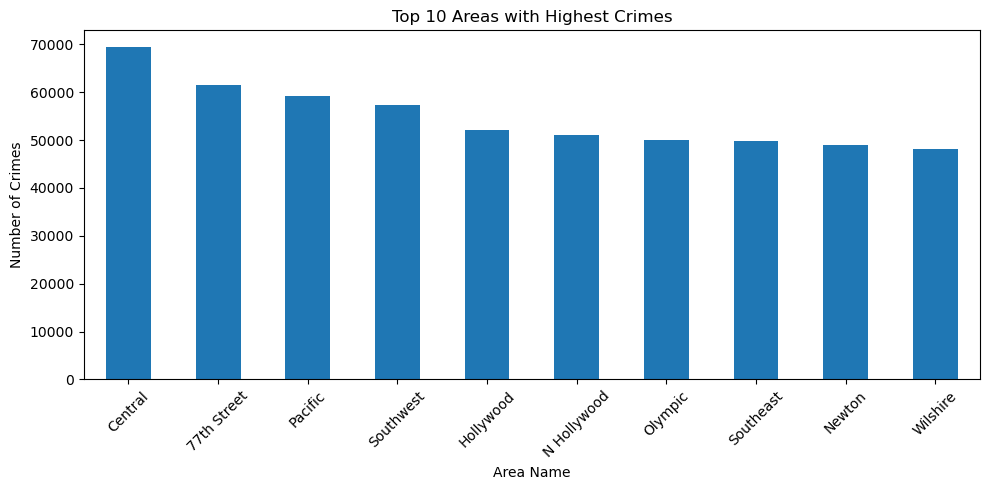

In [90]:
top_areas = df['AREA_NAME'].value_counts().head(10)
top_areas.plot(kind='bar', figsize=(10,5), title='Top 10 Areas with Highest Crimes')
plt.xlabel('Area Name')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


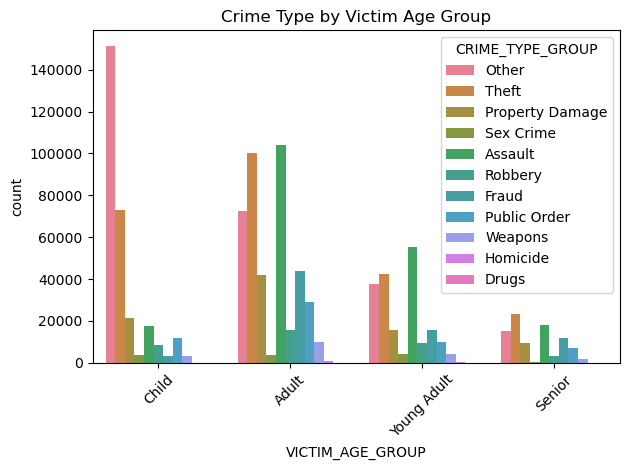

In [91]:
sns.countplot(x='VICTIM_AGE_GROUP', hue='CRIME_TYPE_GROUP', data=df)
plt.title('Crime Type by Victim Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


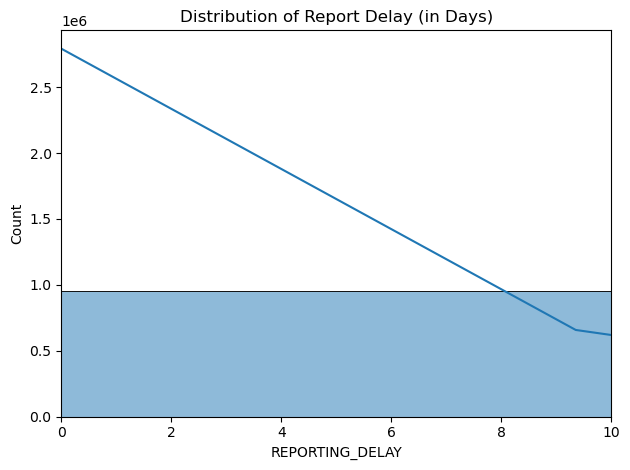

In [95]:
sns.histplot(df['REPORTING_DELAY'], bins=50, kde=True)
plt.title('Distribution of Report Delay (in Days)')
plt.xlim(0, 10) 
plt.tight_layout()
plt.show()
